In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import seaborn as sns

In [62]:
def relabel(row):
    if row['event_type'].strip() == "Riots" :
        return 0
    if row['event_type'].strip() == "Protests" :
        return 1
    if row['event_type'].strip() == "Violence against civilians":
        return 2
    return 3

In [63]:
prot = pd.read_csv("dataset/protest.csv")
riot = pd.read_csv("dataset/riots.csv")
others = pd.read_csv("dataset/others.csv")
df = pd.read_csv("dataset/violence.csv")
df = df.append(prot, ignore_index = True)
df = df.append(riot, ignore_index = True)
df = df.append(others, ignore_index = True)
df['label'] = df.apply (lambda row: relabel(row), axis=1)
columns = ['notes', 'label']
df = df[columns]
df.columns = ['notes', 'label']
df = df.reindex(np.random.permutation(df.index))
len(df)
df.head()

,notes,label
2017,"On January 31st, demonstrators gathered in Kar...",1
4421,"On January 13, locals vandalized a van at the ...",0
5001,"On Dec 28, settlers physically assaulted and i...",0
7752,21 January. The ADF attacked FARDC positions i...,3
1201,"On Dec 24, a fisherman was killed by a policem...",2


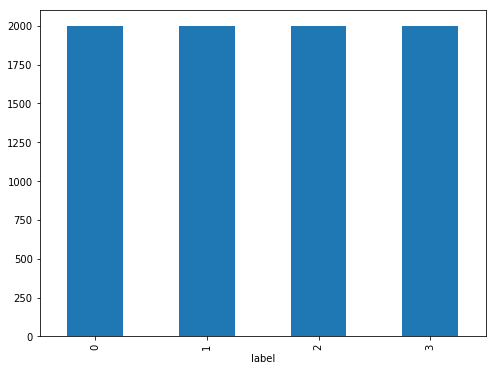

In [64]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').notes.count().plot.bar(ylim=0)
plt.show()

In [65]:
#count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df.notes)
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [66]:
#Word vector to tfidf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df.label, test_size=0.25, random_state=42)
hm = {'0':0,'1':0,'2':0,'3':0}
for d in y_train:
    if d == 0:
        hm['0'] += 1
    elif d == 1:
        hm['1'] += 1
    elif d == 2:
        hm['2'] += 1
    else:
        hm['3'] += 1
print(hm)
clf = MultinomialNB().fit(X_train, y_train)
pickle.dump(clf, open("nb_model.pkl", "wb"))

{'0': 1515, '1': 1488, '2': 1499, '3': 1495}


In [ ]:
#Input Dataset
tf = pd.read_csv("dataset/all.csv")
tf['label'] = tf.apply (lambda row: relabel(row), axis=1)
columns = ['notes', 'label']
tf = tf[columns]
tf.columns = ['notes', 'label']

#Load the model
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("nb_model.pkl","rb"))

X_new_counts = loaded_vec.transform(tf.notes)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)
print(metrics.accuracy_score(predicted, tf.label))
print(metrics.confusion_matrix(predicted, tf.label))
print(metrics.precision_recall_fscore_support(predicted, tf.label))
sns.heatmap(metrics.confusion_matrix(predicted, tf.label))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

0.7928100404169326
[[ 827  635   68  105]
 [  68 2567    5    9]
 [  38    4  136   32]
 [   1    7    2  197]]
(array([0.88543897, 0.7989418 , 0.64454976, 0.57434402]), array([0.5058104 , 0.96904492, 0.64761905, 0.95169082]), array([0.64383028, 0.8758103 , 0.64608076, 0.71636364]), array([1635, 2649,  210,  207]))


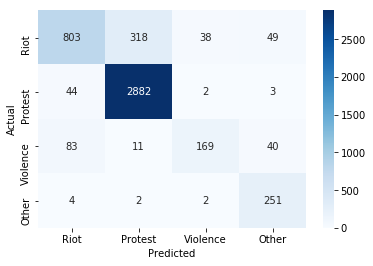

In [11]:
a = [[ 803,  318,   38,   49],
 [  44, 2882,    2,    3],
 [  83,   11,  169,   40],
 [   4,    2,    2,  251]]
sns.heatmap(a, annot=True, fmt='d',cmap="Blues",
            xticklabels=["Riot", "Protest", "Violence", "Other"], yticklabels=["Riot", "Protest", "Violence", "Other"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [56]:
lr_model = LogisticRegression().fit(X_train, y_train)

predicted = lr_model.predict(X_new_tfidf)
print(metrics.accuracy_score(predicted, tf.label))
print(metrics.confusion_matrix(predicted, tf.label))
print(metrics.precision_recall_fscore_support(predicted, tf.label))


0.8610933843863008
[[ 784  300   40   84]
 [  58 2897    2    4]
 [  91   15  167   55]
 [   1    1    2  200]]
(array([0.83940043, 0.90164955, 0.79146919, 0.58309038]), array([0.64900662, 0.97838568, 0.50914634, 0.98039216]), array([0.73202614, 0.93845157, 0.61966605, 0.73126143]), array([1208, 2961,  328,  204]))


/Users/bobbyda/air/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bobbyda/air/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [57]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=1, random_state=0).fit(X_train, y_train)
predicted = rf_model.predict(X_new_tfidf)
print(metrics.accuracy_score(predicted, tf.label))
print(metrics.confusion_matrix(predicted, tf.label))
print(metrics.precision_recall_fscore_support(predicted, tf.label))


0.7092108062114444
[[ 311   23    9   46]
 [ 357 2788   43   88]
 [ 247  348  152  126]
 [  19   54    7   83]]
(array([0.33297645, 0.86772487, 0.72037915, 0.24198251]), array([0.79948586, 0.85103785, 0.17411226, 0.50920245]), array([0.47014361, 0.85930035, 0.2804428 , 0.32806324]), array([ 389, 3276,  873,  163]))


In [58]:
lsvc_model = LinearSVC().fit(X_train, y_train)
predicted = lsvc_model.predict(X_new_tfidf)
print(metrics.accuracy_score(predicted, tf.label))
print(metrics.confusion_matrix(predicted, tf.label))
print(metrics.precision_recall_fscore_support(predicted, tf.label))


0.8732184641565625
[[ 803  318   38   49]
 [  44 2882    2    3]
 [  83   11  169   40]
 [   4    2    2  251]]
(array([0.85974304, 0.89698101, 0.80094787, 0.73177843]), array([0.6647351 , 0.98328216, 0.55775578, 0.96911197]), array([0.74976657, 0.93815104, 0.65758755, 0.83388704]), array([1208, 2931,  303,  259]))


In [2]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_lg
import en_core_web_sm
nlp = en_core_web_lg.load()
#nlp = spacy.load("/Users/praveenkumarrajendran/codebase/air/en_lg")

In [3]:
violence_tokens = set()
violence_doc = nlp("crime kill murder death died criminal convict attack assault assaulted harrasment offence illegal attacker attacked")
for token in violence_doc:
    violence_tokens.add(token.lemma_)

protest_tokens = set()
protest_doc = nlp("protest protester agitation perpetrators rioters riot discord rebellion activist activism demonstration demonstrating resentment grievances agitators ban fast march dharna mourn strike")
for token in protest_doc:
    protest_tokens.add(token.lemma_)

In [4]:
def classify_doc_topic(doc):
    docTokens = set()
    topic = 'Unclassified'
    for token in doc:
        docTokens.add(token.lemma_)
    violence_match = len(docTokens.intersection(violence_tokens))
    protest_match = len(docTokens.intersection(protest_tokens))

    if(violence_match > 0 and protest_match > 0):
        if(violence_match > protest_match):
            topic = 'Violence against Civilians'
        else:
            topic = 'Riots/Protests'
    elif (violence_match > 0):
        topic = 'Violence against Civilians'
    elif (protest_match > 0):
        topic = 'Riots/Protests'    
    return topic